In [2]:
from pprint import pprint
import numpy as np 
import pandas as pd
from tqdm import tqdm
from utils import *
from functools import reduce

In [3]:

def eye_tracking_data_generator():
    data = load_nested_dict('data/Processed', ignore=IGNORE_NO_EYETRACKING) 
    for participant, _data1 in data.items(): #itertools.islice(data.items(), 1):
        for experiment, _data2 in _data1.items():
            start_time, finish_time =  _data2['start_time'], _data2['finish_time']
            eye_data = _data2['eye_tracking']
            gaze_data = eye_data['gaze'].to_numpy().astype(int)
            gaze_stats = {f'gaze at nothing' : 0}
            for task, window_properties in ALL_WINDOW_PROPERTIES.items():
                # for each eyetracking event, check if the participant is looking at the given task
                intaskbox = in_box(eye_data.x.to_numpy(), eye_data.y.to_numpy(), window_properties['position'], window_properties['size']) # 
                gazeintaskbox = np.logical_and(intaskbox, gaze_data)
                result = compute_time_intervals(gazeintaskbox, eye_data.timestamp.to_numpy(), start_time, finish_time)
                gaze_stats[f'gaze at {task}'] = result.proportion # individual stats for each task
                gaze_stats[f'gaze at nothing'] += result.proportion # total gaze at each
            result = compute_time_intervals(gaze_data, eye_data.timestamp.to_numpy(), start_time, finish_time)
            gaze_stats[f'gaze at any'] = result.proportion
            gaze_stats[f'gaze at nothing'] = result.proportion - gaze_stats[f'gaze at nothing']
            
            
            gaze_stats['gaze event count'] = int(gaze_data.sum().item())
            gaze_stats['succade event count'] = int((1-gaze_data).sum().item())
            gaze_stats['eye event count'] = gaze_data.shape[0]
            # number of groups of consequtive gaze events
            gaze_stats['gaze interval count'] = compute_num_groups_of_ones(gaze_data)
            
            # task switching 
            in_task = [in_box(eye_data.x.to_numpy(), eye_data.y.to_numpy(), props['position'], props['size']) for props in ALL_WINDOW_PROPERTIES.values()]
            in_task = [in_task[i].astype(int)*(i+1) for i in range(len(in_task))]
            in_task = reduce(lambda a,b:a+b, in_task)
            in_task = in_task[in_task > 0] # ignore the times where we go out then in the same task
            gaze_stats['task switch count'] = (in_task[:-1] != in_task[1:]).sum().item()
            
            
            # TODO we could also do this for mouse and keyboard input? 
            mouse_data = _data2['mouse']
            for task, data in mouse_data.groupby(mouse_data['task']):
                gaze_stats[f'click at {task}'] = data.shape[0]
            gaze_stats['click at any'] = mouse_data.shape[0]
            
            kdata = _data2['keyboard']
            gaze_stats['keyboard at tracking'] = kdata[kdata['action'] == 'press'].shape[0]

            yield dict(participant = participant, experiment = experiment[3:],
                       ** gaze_stats)
            
df = pd.DataFrame(eye_tracking_data_generator())
# merge performance measures so we might look at correlations
fp = Statistics.compute_failure_proportion_statistics()[['participant', 'experiment', 'total']]
fl = Statistics.compute_failure_length_statistics()[['participant', 'experiment', 'total']]
fc = Statistics.compute_failure_count_statistics()[['participant', 'experiment', 'total']]
df = pd.merge(df, fp.rename(columns={'total':'FP'}), on=['participant', 'experiment'])
df = pd.merge(df, fl.rename(columns={'total':'FL'}), on=['participant', 'experiment'])
df = pd.merge(df, fc.rename(columns={'total':'FC'}), on=['participant', 'experiment'])
df['difficulty'] = df['experiment'].str[-1]

# Remove rows where the eyetracking data is broken (effectively we are removing outliers here)
df = df.drop(df[(df['participant'] == 'P05') & (df['experiment'] == 'icuB')].index)
df = df.drop(df[(df['participant'] == 'P07') & (df['experiment'] == 'icuaB')].index)
df = df.drop(df[(df['participant'] == 'P18') & (df['experiment'] == 'icuaA')].index)
dfA = df[df['difficulty'] == 'A']
dfB = df[df['difficulty'] == 'B']

In [4]:
import numpy as np

# Sample numeric arrays x and y
x = np.array([1, 2, 3])
y = np.array([4, 5, 6])

# Create a NumPy array of strings "X/Y" using vectorized operations
array_strings = np.core.defchararray.add(x.astype(str), np.core.defchararray.add("/", y.astype(str)))

print(array_strings)

['1/4' '2/5' '3/6']


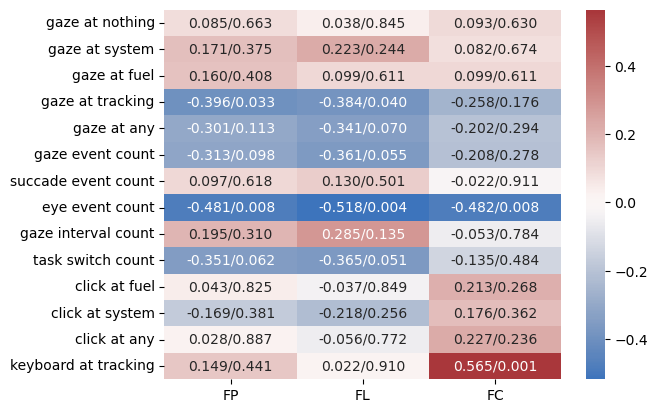

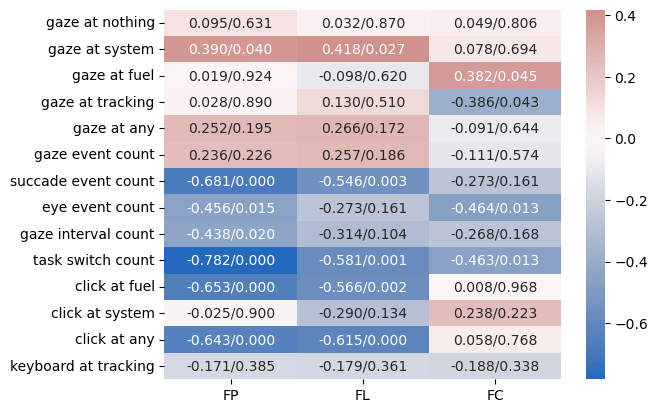

In [7]:
pmetrics = ['FP', 'FL', 'FC']
emetrics = list(df.columns[2:-4])

#print(list(df.columns))
#print(pmetrics, emetrics)

# split by A and B

def compute_correlation(df, pmetrics, emetrics):
    from scipy.stats import pearsonr
    corr_matrix = pd.DataFrame(index=emetrics, columns=pmetrics, dtype=float)
    p_value_matrix = pd.DataFrame(index=emetrics, columns=pmetrics, dtype=float)
    for col1 in pmetrics:
        for col2 in emetrics:
            corr, p_value = pearsonr(df[col1], df[col2])
            p_value_matrix.loc[col2, col1] = p_value
            corr_matrix.loc[col2, col1] = corr
    return corr_matrix, p_value_matrix



corr_matrixA, p_value_matrixA = compute_correlation(dfA, pmetrics, emetrics)
corr_matrixB, p_value_matrixB = compute_correlation(dfB, pmetrics, emetrics)


def combine_str(a, b, precision=3):
    a = np.char.mod('%.{}f'.format(precision), a.to_numpy())
    b = np.char.mod('/%.{}f'.format(precision), b.to_numpy())
    return np.core.defchararray.add(a, b)
    


#pd.merge(corr_matrixA, p_value_matrixA, left_index=True, right_index=True)


import seaborn as sns
cmap = sns.light_palette("seagreen", as_cmap=True).reversed()
cmap = sns.color_palette("vlag", as_cmap=True)
plt.figure()
sns.heatmap(corr_matrixA,  fmt="", annot=combine_str(corr_matrixA, p_value_matrixA), cmap=cmap, center=0) #="YlGnBu")
plt.savefig("./results/A-eyetracking-correlation.png", bbox_inches='tight')
plt.show()
plt.figure()
sns.heatmap(corr_matrixB,  fmt="", annot=combine_str(corr_matrixB, p_value_matrixB), cmap=cmap, center=0) #="YlGnBu")

plt.savefig("./results/B-eyetracking-correlation.png", bbox_inches='tight')
plt.show()

#latex = markdown_table_to_latex(pd.merge(corr_matrixA, p_value_matrixA, left_index=True, right_index=True).to_markdown(floatfmt=".3f"))
#latex = latex.replace("@", " at ").replace("\\_", " ").replace("\\\\", "\\\\ \hline")
#print(latex)
#latex = markdown_table_to_latex(pd.merge(corr_matrixB, p_value_matrixB, left_index=True, right_index=True).to_markdown(floatfmt=".3f"))
#latex = latex.replace("@", " at ").replace("\\_", " ").replace("\\\\", "\\\\ \hline")
#print(latex)



# latex = markdown_table_to_latex(p_value_matrix.round(3).to_markdown())
# latex = latex.replace("@", " at ").replace("\\_", " ").replace("\\\\", "\\\\ \hline")
# print(latex)

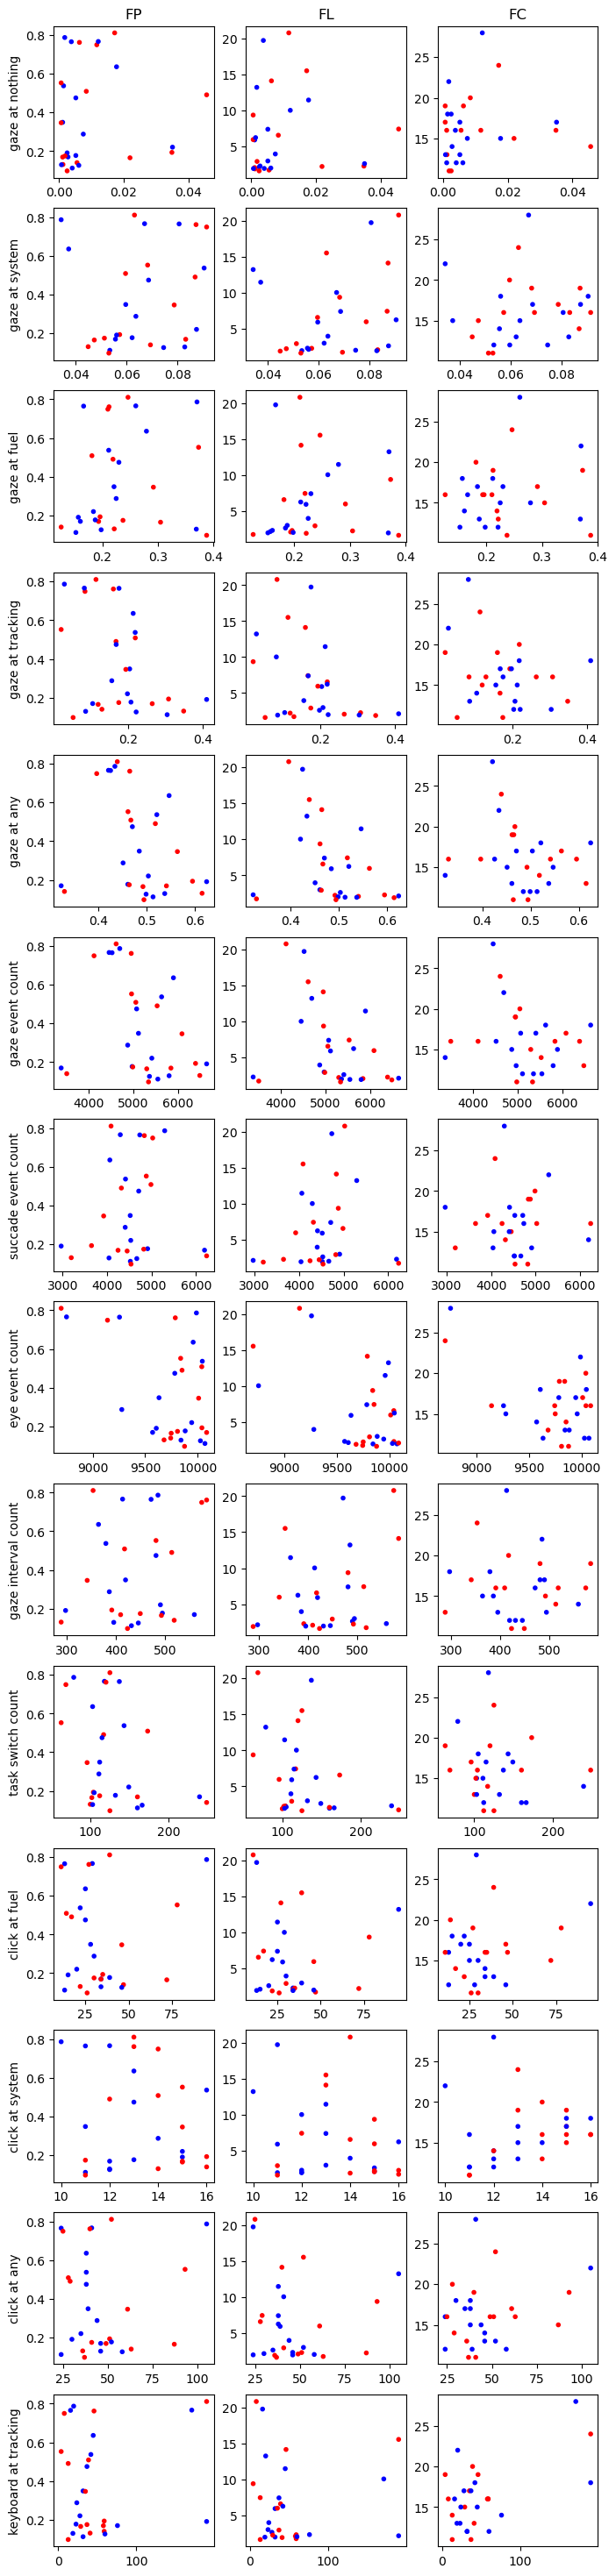

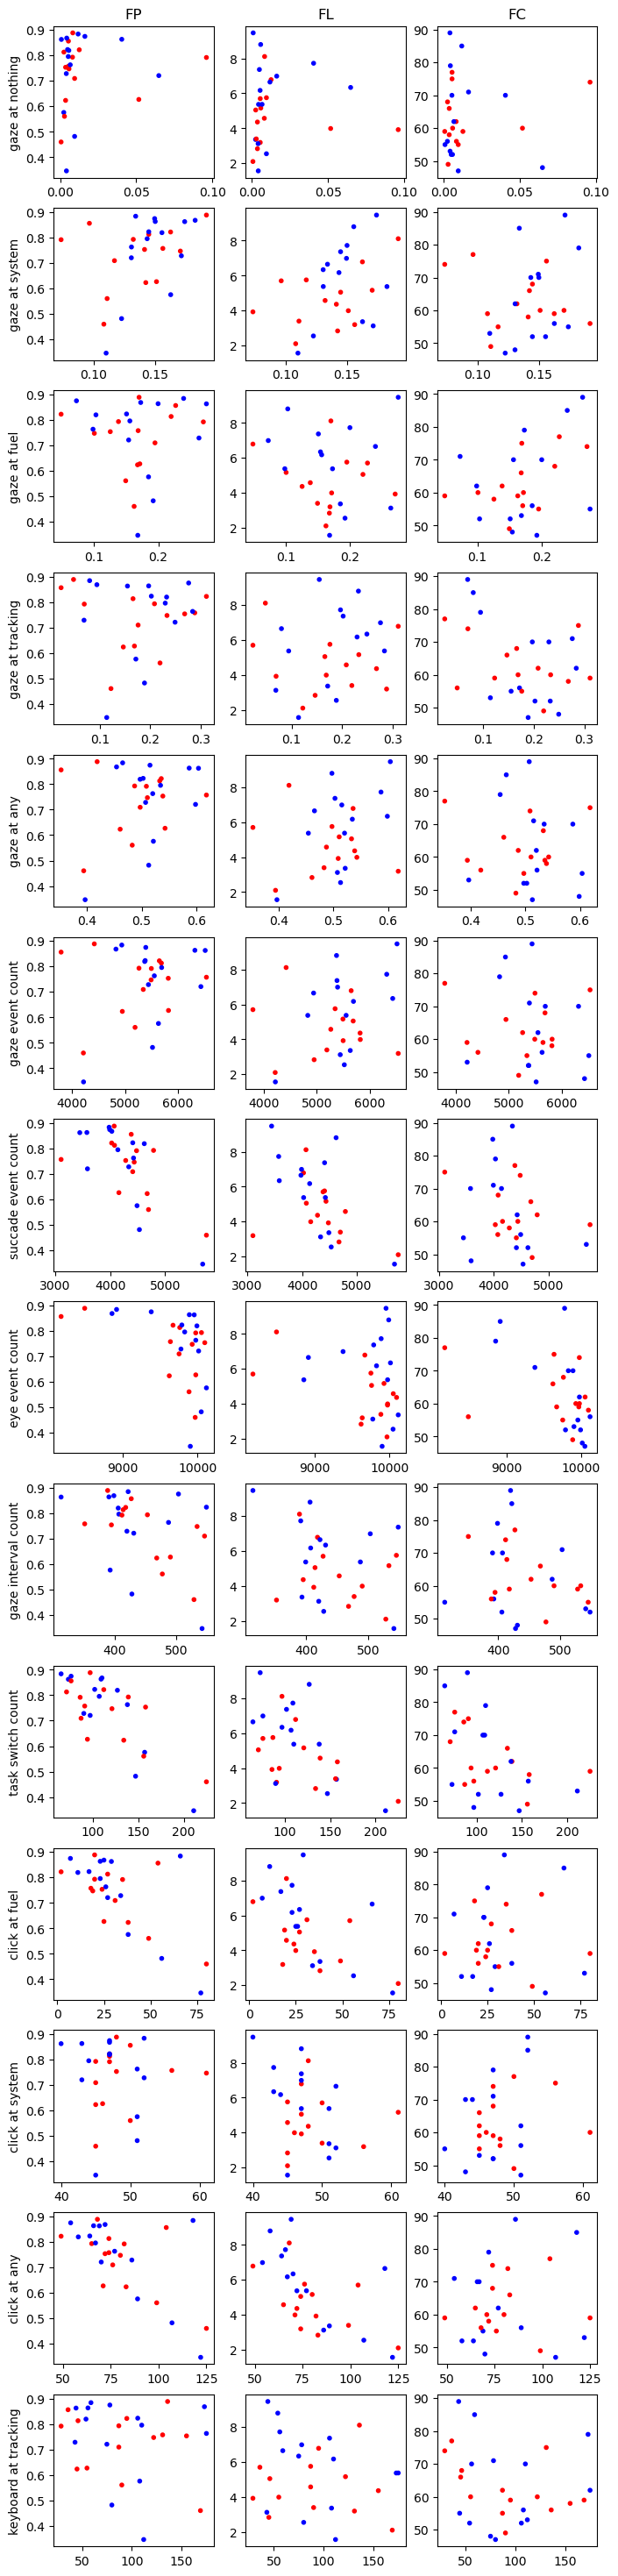

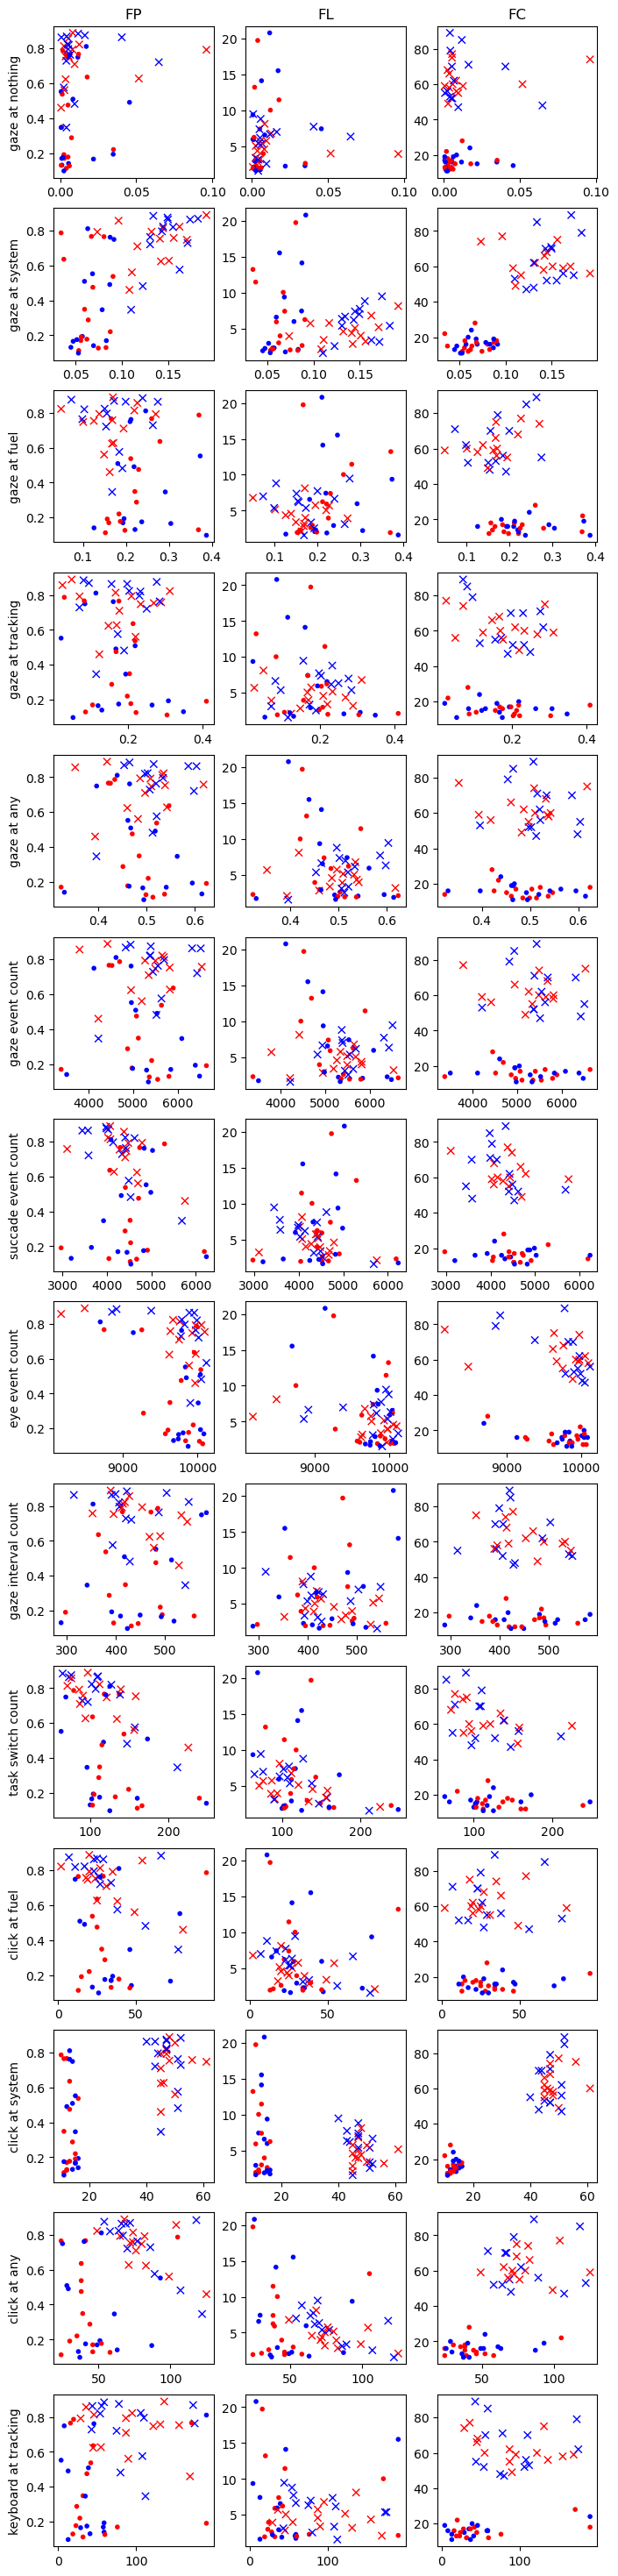

In [6]:
import matplotlib.pyplot as plt
import matplotlib

cmap = matplotlib.colormaps['tab10']

def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc


def plot(df, emetrics, pmetrics, c=None, m="."):
    fig, axes = plt.subplots(figsize=(8,8/len(pmetrics)*len(emetrics)),nrows=len(emetrics), ncols=len(pmetrics))
    for _axes, e in zip(axes, emetrics):
        for ax, p in zip(_axes, pmetrics):
            mscatter(df[e].to_numpy(), df[p].to_numpy(), ax=ax, m=m, c=c)
    #fig.tight_layout()

    for ax, e in zip(axes[:,0], emetrics):
        ax.set_ylabel(e.replace("@", " at "))
    for ax, p in zip(axes[0], pmetrics):
        ax.set_title(p.replace("@", " at "))
        
        
_emetrics = ['gaze@system', 'gaze@fuel', 'task switch count', 'click@system', 'keyboard@tracking']
_emetrics = emetrics



# cols = ['keyboard@tracking', 'gaze@tracking']
# plot(dfA, cols, cols)
# plot(dfB, cols, cols)
# print(compute_correlation(dfA, cols, cols))
# print(compute_correlation(dfB, cols, cols))


# eye_counts = ['eye event count', 'gaze event count', 'succade event count', 'task switch count']
# plot(dfA, eye_counts, eye_counts)
# plot(dfB, eye_counts, eye_counts)

_df = dfA
d = _df['difficulty'].astype('category').cat.codes.astype(int)
a = _df['experiment'].str[-2].astype('category').cat.codes.astype(int)
c = np.array(['red', 'blue'])[a]
m = np.array([".", "x"])[d]
plot(_df, emetrics, pmetrics, c=c, m=m)

_df = dfB
d = _df['difficulty'].astype('category').cat.codes.astype(int)
a = _df['experiment'].str[-2].astype('category').cat.codes.astype(int)
c = np.array(['blue', 'red'])[a]
m = np.array([".", "x"])[d]
plot(_df, emetrics, pmetrics, c=c, m=m)

_df = df
d = _df['difficulty'].astype('category').cat.codes.astype(int)
a = _df['experiment'].str[-2].astype('category').cat.codes.astype(int)
c = np.array(['blue', 'red'])[a]
m = np.array([".", "x"])[d]
plot(_df, emetrics, pmetrics, c=c, m=m)







In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
x = np.random.randn(10)
y = np.random.randn(10)
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '*', 'h', '8']

# Plot the scatter plot with specified markers
plt.scatter(x, y, marker=markers)

plt.show()